<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/Caltec101-Fine-Tuned-ResNet50/caltech_resnetv2_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import pathlib
import numpy as np
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings("ignore")

# Config

In [ ]:
class Config:
    BATCH_SIZE = 32
    IMAGE_SIZE = (224, 244)
    BASE_LR = 1e-3
    FINETUNE_LR = 1e-5
    SEED = 123
    TOTAL_EPOCHS = 40
    INITIAL_EPOCHS = 12
    NUM_CLASSES = 0
    PATIENCE = 8

config = Config()

# Load Dataset

In [ ]:
data_dir = pathlib.Path('/kaggle/input/caltech-101/caltech-101')
print(f"Data directory set to: {data_dir}")

Data directory set to: /kaggle/input/caltech-101/caltech-101


In [ ]:
all_classes = sorted([item.name for item in data_dir.iterdir() if item.is_dir() and not item.name.startswith('.')])
Config.NUM_CLASSES = len(all_classes)

In [ ]:
print(f"Total number of classes found: {Config.NUM_CLASSES}")
print("First 10 classes:")
for cls in all_classes[:10]:
    print(f"- {cls}")

filtered_class_names = [cls for cls in all_classes if cls != 'BACKGROUND_Google']
Config.NUM_CLASSES = len(filtered_class_names)

print(f"\n\nNumber of classes after filtering 'BACKGROUND_Google': {Config.NUM_CLASSES}")
print("First 10 filtered classes:")
for cls in filtered_class_names[:10]:
    print(f"- {cls}")

Total number of classes found: 102
First 10 classes:
- BACKGROUND_Google
- Faces
- Faces_easy
- Leopards
- Motorbikes
- accordion
- airplanes
- anchor
- ant
- barrel


Number of classes after filtering 'BACKGROUND_Google': 101
First 10 filtered classes:
- Faces
- Faces_easy
- Leopards
- Motorbikes
- accordion
- airplanes
- anchor
- ant
- barrel
- bass


# Load Tensorflow Dataset

In [ ]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=config.SEED,
    image_size=config.IMAGE_SIZE,
    batch_size=config.BATCH_SIZE,
    label_mode='categorical',
    class_names=filtered_class_names
)

validation_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=config.SEED,
    image_size=config.IMAGE_SIZE,
    batch_size=config.BATCH_SIZE,
    label_mode="categorical",
    class_names=filtered_class_names
)

Found 8677 files belonging to 101 classes.
Using 6942 files for training.
Found 8677 files belonging to 101 classes.
Using 1735 files for validation.


## Preprocess & Optimization

In [ ]:
train_ds = train_ds \
            .cache() \
            .prefetch(buffer_size=tf.data.AUTOTUNE)

validation_ds = validation_ds \
            .cache() \
            .prefetch(buffer_size=tf.data.AUTOTUNE)


## Data Augmentation

In [ ]:
data_augmentation_strong = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15), # Increased rotation to 0.15 (~27 degrees)
    tf.keras.layers.RandomTranslation(
      height_factor=0.1, # Shift up/down by up to 10%
      width_factor=0.1,  # Shift left/right by up to 10%
      fill_mode='reflect'
    ),

    tf.keras.layers.RandomZoom(0.15), # Increased zoom
    tf.keras.layers.RandomContrast(0.3), # Increased contrast variation
    tf.keras.layers.RandomBrightness(0.2), # Added brightness variation (NEW)

], name="data_augmentation_strong")

# Train `ResNet50` With new Heads

*Load ResNet*

In [ ]:
base_resnet = ResNet50(
    input_shape=config.IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

base_resnet.trainable=False

*Define New Heads*

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

def build_transfer_model(basemodel, num_classes):
    inputs = Input(shape=(config.IMAGE_SIZE + (3,)))
    x = data_augmentation_strong(inputs)
    x = resnet_preprocess(x)
    x = basemodel(x, training=False)
    x = GlobalAveragePooling2D(name="gap_layer")(x)
    x = Dense(1024, activation="relu", name="dense_hidden1")(x)
    x = Dense(512, activation="relu", name="dense_hidden_2")(x)
    outputs = Dense(
        num_classes,
        activation="softmax",
        name="output_layer"
    )(x)

    model = KerasModel(inputs, outputs, name="ResNet50_Caltech101")
    return model

model_resnet = build_transfer_model(base_resnet, config.NUM_CLASSES)

model_resnet.summary()

Model: "ResNet50_Caltech101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation_… │ (None, 224, 244,  │          0 │ input_layer_11[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, 224, 244)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, 224, 244)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, 224, 244)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_4 (Stack)     │ (None, 224, 244,  │          0 │ get_item_12[0][0… │
│                     │ 3)                │            │ get_item_13[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 224, 244,  │          0 │ stack_4[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 8,      │ 23,587,712 │ add_4[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap_layer           │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_hidden1       │ (None, 1024)      │  2,098,176 │ gap_layer[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_hidden_2      │ (None, 512)       │    524,800 │ dense_hidden1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 101)       │     51,813 │ dense_hidden_2[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,262,501 (100.18 MB)

 Trainable params: 2,674,789 (10.20 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model_resnet.compile(
    optimizer=Adam(learning_rate=config.BASE_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_head = model_resnet.fit(
    train_ds,
    epochs=config.INITIAL_EPOCHS,
    validation_data=validation_ds
)

Epoch 1/12
217/217 ━━━━━━━━━━━━━━━━━━━━ 57s 229ms/step - accuracy: 0.4694 - loss: 2.7182 - val_accuracy: 0.8035 - val_loss: 0.6658
Epoch 2/12
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.8152 - loss: 0.6724 - val_accuracy: 0.8507 - val_loss: 0.5413
Epoch 3/12
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.8486 - loss: 0.4924 - val_accuracy: 0.8622 - val_loss: 0.5261
Epoch 4/12
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.8800 - loss: 0.4143 - val_accuracy: 0.8622 - val_loss: 0.5194
Epoch 5/12
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.8974 - loss: 0.3599 - val_accuracy: 0.8697 - val_loss: 0.5290
Epoch 6/12
217/217 ━━━━━━━━━━━━━━━━━━━━ 42s 191ms/step - accuracy: 0.8980 - loss: 0.3419 - val_accuracy: 0.8922 - val_loss: 0.4610
Epoch 7/12
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.9065 - loss: 0.3126 - val_accuracy: 0.8772 - val_loss: 0.5297
Epoch 8/12
217/217 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - accuracy: 0.9044 - loss: 0

# Fine Tuning `ResNet`'s Layers

In [ ]:
# Unfeereze the base model
base_resnet.trainable=True

# Select early layers
# freezing the first 140 layers of resnet50
fine_tune_at = 140
for layer in base_resnet.layers[:fine_tune_at]:
    layer.trainable=False

print(f"\nNumber of ResNet50 layers opened for Fine-Tuning: {len(base_resnet.layers) - fine_tune_at}")


Number of ResNet50 layers opened for Fine-Tuning: 35


*Recompile Model*

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks_fine_tune = [
    # Stop training if val_loss does not improve for 8 consecutive epochs
    EarlyStopping(
        monitor='val_loss',
        patience=config.PATIENCE,
        mode='min',
        restore_best_weights=True # Restore weights from the best epoch found
    ),
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        filepath='resnet50_best_caltech.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

In [ ]:
model_resnet.compile(
    optimizer=Adam(learning_rate=config.FINETUNE_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model_resnet.fit(
    train_ds,
    epochs=config.TOTAL_EPOCHS,
    initial_epoch=history_head.epoch[-1],
    validation_data=validation_ds,
    callbacks=callbacks_fine_tune
)

Epoch 12/40
217/217 ━━━━━━━━━━━━━━━━━━━━ 73s 274ms/step - accuracy: 0.8959 - loss: 0.3631 - val_accuracy: 0.9153 - val_loss: 0.4152
Epoch 13/40
217/217 ━━━━━━━━━━━━━━━━━━━━ 56s 257ms/step - accuracy: 0.9463 - loss: 0.1731 - val_accuracy: 0.9210 - val_loss: 0.3818
Epoch 14/40
217/217 ━━━━━━━━━━━━━━━━━━━━ 56s 259ms/step - accuracy: 0.9697 - loss: 0.1058 - val_accuracy: 0.9239 - val_loss: 0.3705
Epoch 15/40
217/217 ━━━━━━━━━━━━━━━━━━━━ 56s 259ms/step - accuracy: 0.9727 - loss: 0.1021 - val_accuracy: 0.9285 - val_loss: 0.3714
Epoch 16/40
217/217 ━━━━━━━━━━━━━━━━━━━━ 56s 260ms/step - accuracy: 0.9708 - loss: 0.0863 - val_accuracy: 0.9285 - val_loss: 0.3654
Epoch 17/40
217/217 ━━━━━━━━━━━━━━━━━━━━ 56s 259ms/step - accuracy: 0.9797 - loss: 0.0730 - val_accuracy: 0.9314 - val_loss: 0.3596
Epoch 18/40
217/217 ━━━━━━━━━━━━━━━━━━━━ 56s 258ms/step - accuracy: 0.9861 - loss: 0.0568 - val_accuracy: 0.9303 - val_loss: 0.3592
Epoch 19/40
217/217 ━━━━━━━━━━━━━━━━━━━━ 56s 258ms/step - accuracy: 0.9838 -

# Evaluation

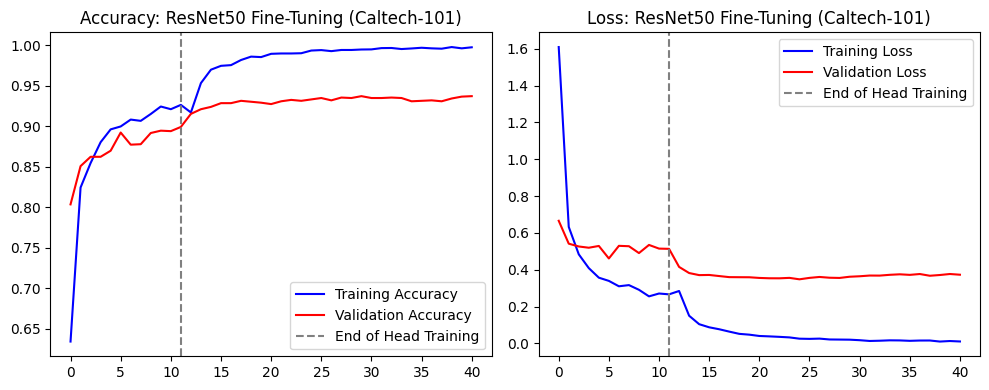

In [ ]:
def plot_fine_tuning_curves(history_head, history_ft, initial_epochs):
    # Combine history
    acc = history_head.history['accuracy'] + history_ft.history['accuracy']
    val_acc = history_head.history['val_accuracy'] + history_ft.history['val_accuracy']
    loss = history_head.history['loss'] + history_ft.history['loss']
    val_loss = history_head.history['val_loss'] + history_ft.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
    plt.axvline(x=initial_epochs - 1, color='gray', linestyle='--', label='End of Head Training')
    plt.legend(loc='lower right')
    plt.title('Accuracy: ResNet50 Fine-Tuning (Caltech-101)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
    plt.axvline(x=initial_epochs - 1, color='gray', linestyle='--', label='End of Head Training')
    plt.legend(loc='upper right')
    plt.title('Loss: ResNet50 Fine-Tuning (Caltech-101)')

    plt.tight_layout()
    plt.show()

plot_fine_tuning_curves(history_head, history_ft, config.INITIAL_EPOCHS)